# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 6 Multilayer Perceptron ##

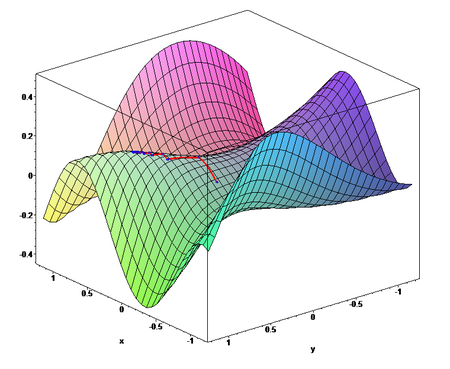

# **Review** ##
Before we start, let's have a quick recap of the lecture material.

## Multilayer Perceptron

Unlike single-layer perceptron, increasing the number of layers enhances the model's representation power to handle a broader range of problems.

A multilayer perceptron generally consists of three types of layers:
*   Input layer
*   Hidden layer
*   Output layer



Example playground:
> __https://playground.tensorflow.org/__

classification## Loss function

As the parameters (weights and biases) are updated by backpropagation, it is important to define the loss function so that the derivative can be computed step by step from the loss function.
> The loss function is the difference between the ground truth and your prediction result; we aim to minimize the loss to make the prediction closer to the ground truth.

> In Keras, you can find the available loss functions at https://keras.io/api/losses/.

Following is a visualization for common losses used for classification and regression on one-dimensional data. The x-axis is `y_pred-y_label`. You can see how these loss functions penalize incorrect predictions.

<ipython-input-1-d7dc5487211c>:21: RuntimeWarning: invalid value encountered in log
  cross_entropy_loss = -np.log(x)


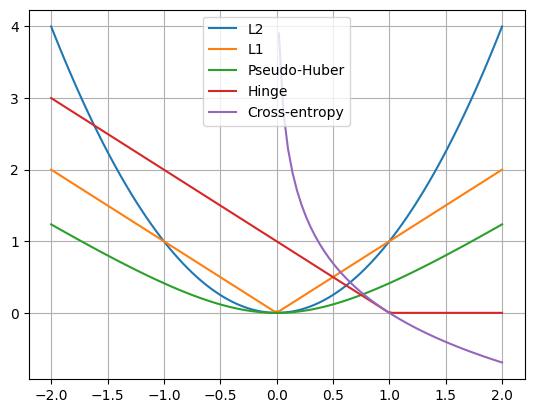

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values for the plot
x = np.linspace(-2, 2, 100)

# Define the L2 loss function
l2_loss = x**2

# Define the L1 loss function
l1_loss = np.abs(x)

# Define the Pseudo-Huber loss function
delta = 1
pseudo_huber_loss = delta**2 * (np.sqrt(1 + (x/delta)**2) - 1)

# Define the Hinge loss function
hinge_loss = np.maximum(0, 1 - x)

# Define the Cross-entropy loss function
cross_entropy_loss = -np.log(x)

# Plot the loss functions
plt.plot(x, l2_loss, label='L2')
plt.plot(x, l1_loss, label='L1')
plt.plot(x, pseudo_huber_loss, label='Pseudo-Huber')
plt.plot(x, hinge_loss, label='Hinge')
plt.plot(x, cross_entropy_loss, label='Cross-entropy')
plt.grid()
plt.legend()
plt.show()

Here is a table summarizing the properties and benefits of the different loss functions we have just explored:

| Loss function | Use | Benefits | Disadvantages |
| --- | --- | --- | --- |
| L2 | Regression | More stable | Less robust |
| L1 | Regression | More robust | Less stable |
| Pseudo-Huber | Regression | More robust and stable | One more parameter |
| Hinge | Classification | Creates a max margin for use in SVM | Unbounded loss affected by outliers |
| Cross-entropy | Classification | More stable | Unbounded loss, less robust |

## Gradient Descent
We update the parameter $\rho$ by calculating its gradient $\nabla \rho$ for a learning rate of $\eta$,
> $\rho = \rho - \eta \nabla \rho$

If you are interested in more details of backpropagation and how to compute the gradient for nodes in different layers, you may check out the example and illustration in the YouTube video by 3Blue1Brown at https://www.youtube.com/watch?v=Ilg3gGewQ5U.

To give a basic concept here, for example, we have the below network structure.

Given that $a_i = f_i(w_{i-1} a_{i-1})$ where $a_0 = x$, $w_i$ is the weight parameter and $f_i$ is the activation function of layer i in the network.

Network: <br>
input $x$  -($w_1$)-> $a_1,f_1$ -($w_2$)-> $a_2, f_2$ -($w_3$)-> $a_3, f_3$ --> $y$ --> Loss function $L$

Let's say we now want to update $w_2$ through backpropagation. Then we will need to compute $w_2 = w_2 - \eta \nabla w_2$

$\nabla w_2 = \frac{\partial L}{\partial w_2} = \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial a_3}\frac{\partial a_3}{\partial f_2}\frac{\partial f_2}{\partial a_2}\frac{\partial a_2}{\partial w_2}$

while $\nabla w_3 = \frac{\partial L}{\partial w_3} = \frac{\partial L}{\partial f_3}\frac{\partial f_3}{\partial a_3}\frac{\partial a_3}{\partial w_3}$, and you will find that some computation results can be reused.

The following provides a simple animation showing how gradient descent works on regressing a basic function $3x^2$.

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from matplotlib import animation

def grad_1D(expr, x_values, learning_rate, training_epochs, display_animation=False):
    """
    expr : Sympy expression like 3*x**2 (x symbol)
    x_values : np.linspace(a,b, n)
    learning_rate, training_epochs = z, r
    display_animation : if True, will return two objects to visualizing it (example below)
    """

    x = sp.symbols("x")
    func = sp.lambdify(x, expr, "numpy")
    deriv = sp.diff(expr)
    deriv_func = sp.lambdify(x, deriv, "numpy")

    #algorithm for Gradient Descent
    local_min = np.random.choice(x_values,1)
    initial_local_min = local_min
    print(f"Initial Random Local Min {initial_local_min}")
    model_params = np.zeros((training_epochs, 2)) #shape epochs x 2 cols
    for i in range(0, training_epochs):
        grad = deriv_func(local_min)
        local_min = local_min - (grad*learning_rate)
        model_params[i,0] = local_min[0]
        model_params[i,1] = grad[0]
    print(f"Final Local Min after {training_epochs} epochs: {local_min}")


    if display_animation:
        #prepare animation
        grad_fig, ax = plt.subplots(figsize=(12,6), dpi=100)
        ax.plot(x_values, func(x_values), label=f"${sp.latex(expr)}$")
        ax.plot(x_values, deriv_func(x_values), label=f"dy/dx ${sp.latex(deriv)}$")

        plt.title(f"Empirical Local Minimum: {local_min[0]}")
        plt.axhline(0, color='white',linewidth=0.5)
        plt.axvline(0, color='white',linewidth=0.5)
        plt.grid(color="gray", linestyle="--", linewidth=0.5)
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.legend()
        plt.close()
        def tangent_line(x, x1, y1):
            # m*x+b
            return deriv_func(x1)*(x-x1) + y1

        title = ax.set_title('', fontweight="bold")
        local_min_scat = ax.scatter(initial_local_min, func(initial_local_min), color="orange")
        initial_tangent_range = np.linspace(initial_local_min-0.5, initial_local_min+0.5, 10)
        tangent_plot = ax.plot(initial_tangent_range, tangent_line(x=initial_tangent_range,
                                                                   x1=initial_local_min,
                                                                   y1=func(initial_local_min)), linestyle="--",  color="orange", linewidth=2)[0]
        grad_annotation = ax.annotate(
            'Gradient={0:2f}'.format(deriv_func(initial_local_min[0])),
            xy=(initial_local_min,func(initial_local_min)), xytext=(initial_local_min,func(initial_local_min)+1),
            arrowprops = {'arrowstyle': "-", 'facecolor' : 'orange'},
            textcoords='data', color='orange' , rotation=20, fontweight="bold"
        )
        def drawframe(epoch):
            title.set_text('Epoch={0:4d}'.format(epoch, model_params[epoch, 1]))
            x1 = model_params[epoch, 0]
            y1 = func(model_params[epoch, 0])
            local_min_scat.set_offsets((x1, y1))
            tangent_range = np.linspace(x1-0.5, x1+0.5, 10)
            tangent_values = tangent_line(x=tangent_range, x1=x1 ,y1=y1)
            tangent_plot.set_xdata(tangent_range)
            tangent_plot.set_ydata(tangent_values)
            grad_annotation.set_position((x1, y1+1))
            grad_annotation.xy = (x1, y1)
            grad_annotation.set_text('Gradient={0:2f}'.format(model_params[epoch, 1]))
            return local_min_scat,

        # blit=True re-draws only the parts that have changed.
        anim = animation.FuncAnimation(grad_fig, drawframe, frames=training_epochs, repeat=False, interval=500, blit=True)
        writer = animation.PillowWriter(fps=30,
                                        metadata=dict(artist='Me'),
                                        bitrate=1800)
        return anim, writer

The following code generates the demo for gradient descent, you can change the learning rate and see how the learning rate influences the speed of convergence.

In [3]:
x = sp.symbols("x")

x_values = np.linspace(-2,2,20)
anim, writer = grad_1D(expr=3*x**2, #it calculates the f'(x) automatically
                       x_values=x_values, learning_rate=0.01, training_epochs=50, display_animation=True)
from IPython.display import HTML
HTML(anim.to_html5_video()) #render the video in jupyterlab

Initial Random Local Min [1.36842105]
Final Local Min after 50 epochs: [0.06203152]


## The procedure for applying MLP to a practical problem

1. Import the required libraries and define global variables
2. Load the data
3. Explore the data and preprocess it
4. Normalize the dataset
5. Build the model
6. Compile the model
7. Train the model
8. Evaluate the model's accuracy
9. Save the trained model
10. Use the saved model

In the official documentation of Keras, there is a simple demo for the pipeline to apply MLP to solve a practical image classification problem. Please check https://keras.io/examples/vision/mlp_image_classification/

## Some remarks for MLP


-   You may want to keep the number of layers at a reasonable level.
    - Normally a very deep neural network model composed solely of dense layers may not perform well due to the gradient exploring/ vanishing problem.

-   Adding regularization helps keep the weights small, making the model less likely to have large variance (i.e., being sensitive to noise and fluctuations in data).

-   To backpropagate, it is essential to choose differentiable activation functions. <br> In addition, activation functions in the hidden layers are used to add non-linearity to the neural network, thus enabling greater model representation power.
<br>
-   For the output layer, the activation function used depends on the type of classification:
    - Binary classification: One node, sigmoid activation.
    - Multiclass classification: One node per class, softmax activation
    - Multilabel classification: One node per class, sigmoid activation
    - Regression: Onde node, linear activation
<br>
-   Setting the batch size (minibatch gradient descent) instead of training for an iteration on a single batch with all samples (batch gradient descent) has the following benefits:
    - Reduced memory consumption.
    - Faster training time within an iteration.
    - Easier to escape from local minima.


## Layers

You will mainly work with these two types of layers.

You can find sample inputs and outputs of each layer in the Keras documentation.  

- Dense(): https://keras.io/api/layers/core_layers/dense/
    - It is a regular densely-connected neural network layer. Dense implements the operation: `output = activation(dot(input, kernel) + bias)`, where activation is the element-wise activation function passed as the activation argument, the kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if `use_bias` is True). Note: If the input to the layer has a rank greater than 2, Dense computes the dot product between the inputs and the kernel along the last axis of the inputs and axis 0 of the kernel (using tf.tensordot). For example, if the input has dimensions `(batch_size, d0, d1)`, we create a kernel with shape `(d1, units)`, and the kernel operates along axis 2 of the input, on every sub-tensor of shape `(1, 1, d1)` (there are `batch_size * d0` such sub-tensors). In this case, the output will have the shape `(batch_size, d0, units)`.

- Dropout(): https://keras.io/api/layers/regularization_layers/dropout/
    - The Dropout layer randomly sets input units to 0 with a frequency of the rate at each step during training, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) so that the sum of all inputs remains unchanged. Note that the Dropout layer only applies when training is set to True in `call()`, meaning no values are dropped during inference. When using `model.fit()`, the training argument will be automatically set to True. In other contexts, you can explicitly set the training argument to True when calling the layer. (This contrasts with setting `trainable=False` for a Dropout layer. The trainable attribute does not affect the layer's behavior, as Dropout has no variables or weights that can be frozen during training.)



## Self-learning materials

1. Multi-class vs Multi-label classification: \\
https://medium.com/mlearning-ai/multi-class-vs-multi-label-classification-whats-the-difference-2840a87c8dfe

2. Batch, Mini Batch and Stochastic (or single-instance) gradient descent: \\
https://sweta-nit.medium.com/batch-mini-batch-and-stochastic-gradient-descent-e9bc4cacd461

3. Regularization: \\
https://towardsdatascience.com/a-comprehensive-guide-of-regularization-techniques-in-deep-learning-c671bb1b2c67

4. Dropout: \\
https://towardsdatascience.com/dropout-in-neural-networks-47a162d621d9